# **Assignment 1**

In [51]:
import time, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

from xgboost import XGBClassifier

DATA_DIR = Path("Census Income Data Set")
cols = ["age","workclass","fnlwgt","education","education-num","marital-status",
        "occupation","relationship","race","sex","capital-gain","capital-loss",
        "hours-per-week","native-country","income"]

def load_adult(train_path, test_path):
    tr = pd.read_csv(train_path, names=cols, na_values="?", skipinitialspace=True)
    te = pd.read_csv(test_path,  names=cols, na_values="?", skipinitialspace=True)
    for df in (tr, te):
        df["income"] = df["income"].astype(str).str.replace(".","",regex=False).str.strip()
    tr = tr.dropna(subset=["income"]).reset_index(drop=True)
    te = te.dropna(subset=["income"]).reset_index(drop=True)
    return tr, te

train_df, test_df = load_adult(DATA_DIR / "adult.data", DATA_DIR / "adult.test")
print(train_df.shape, test_df.shape)
train_df.head(3)


(32561, 15) (16282, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [52]:

y_train = (train_df["income"] == ">50K").astype(int)
y_test  = (test_df["income"]  == ">50K").astype(int)
X_train = train_df.drop(columns=["income"])
X_test  = test_df.drop(columns=["income"])

cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)


Numeric features: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [53]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Logistic Regression
numeric_transformer_lr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# XGBoost
numeric_transformer_xgb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=True))  # <-- use sparse_output here
])

preprocess_lr = ColumnTransformer(transformers=[
    ("num", numeric_transformer_lr, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

preprocess_xgb = ColumnTransformer(transformers=[
    ("num", numeric_transformer_xgb, num_cols),
    ("cat", categorical_transformer, cat_cols)
])




In [54]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# 3-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=6227)

# Logistic Regression pipeline
lr_pipe = Pipeline(steps=[
    ("preprocess", preprocess_lr),
    ("clf", LogisticRegression(max_iter=2000, solver="saga", n_jobs=-1))
])

lr_param_dist = {
    "clf__C": [0.1, 0.5, 1, 2, 3],
    "clf__penalty": ["l2"],
    "clf__class_weight": [None, "balanced"]
}

lr_search = RandomizedSearchCV(
    estimator=lr_pipe,
    param_distributions=lr_param_dist,
    n_iter=6,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=6227,
    refit=True,
    verbose=0
)

# XGBoost pipeline
xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess_xgb),
    ("clf", XGBClassifier(
        n_estimators=400,
        learning_rate=0.15,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        tree_method="hist",
        n_jobs=-1,
        eval_metric="logloss",
        random_state=6227
    ))
])

xgb_param_dist = {
    "clf__n_estimators": [300, 400, 600],
    "clf__learning_rate": [0.1, 0.15, 0.2],
    "clf__max_depth": [4, 6, 8],
    "clf__subsample": [0.8, 0.9, 1.0],
    "clf__colsample_bytree": [0.8, 0.9, 1.0],
    "clf__reg_lambda": [0.5, 1.0, 1.5]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_param_dist,
    n_iter=8,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=6227,
    refit=True,
    verbose=0
)



In [55]:
import time
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             roc_curve, precision_recall_curve)

def train_and_eval(estimator, name, Xtr, ytr, Xte, yte):
    """Train a model, record timing, compute metrics and curves."""
    # --- Training ---
    t0 = time.perf_counter()
    estimator.fit(Xtr, ytr)
    t1 = time.perf_counter()

    # --- Prediction ---
    y_pred = estimator.predict(Xte)
    t2 = time.perf_counter()

    # --- Scores for curves/AUC ---
    try:
        y_score = estimator.predict_proba(Xte)[:, 1]
    except Exception:
        try:
            y_score = estimator.decision_function(Xte)
        except Exception:
            y_score = y_pred.astype(float)

    # --- Metrics ---
    acc = accuracy_score(yte, y_pred)
    pre = precision_score(yte, y_pred, zero_division=0)
    rec = recall_score(yte, y_pred, zero_division=0)
    f1  = f1_score(yte, y_pred, zero_division=0)
    auc = roc_auc_score(yte, y_score)
    ap  = average_precision_score(yte, y_score)

    # --- Curves ---
    fpr, tpr, _ = roc_curve(yte, y_score)
    pr_p, pr_r, _ = precision_recall_curve(yte, y_score)

    return {
        "Model": name,
        "Accuracy": acc, "Precision": pre, "Recall": rec, "F1": f1,
        "ROC_AUC": auc, "PR_AUC(AP)": ap,
        "Train(s)": t1 - t0, "Predict(s)": t2 - t1,
        "FPR": fpr, "TPR": tpr, "PR_Precision": pr_p, "PR_Recall": pr_r
    }

# Clean numeric columns in X_train and X_test 
def clean_numeric(df, num_cols):
    df_clean = df.copy()
    for col in num_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    return df_clean

X_train_clean = clean_numeric(X_train, num_cols)
X_test_clean  = clean_numeric(X_test, num_cols)

# Remove rows with NaN in any numeric column
train_mask = X_train_clean[num_cols].notnull().all(axis=1)
test_mask  = X_test_clean[num_cols].notnull().all(axis=1)

X_train_final = X_train_clean[train_mask].reset_index(drop=True)
y_train_final = y_train[train_mask].reset_index(drop=True)
X_test_final  = X_test_clean[test_mask].reset_index(drop=True)
y_test_final  = y_test[test_mask].reset_index(drop=True)

# --- Train both models and collect results ---
summaries = []
summaries.append(train_and_eval(lr_search,  "Logistic Regression (tuned)", X_train_final, y_train_final, X_test_final, y_test_final))
summaries.append(train_and_eval(xgb_search, "XGBoost (tuned)",              X_train_final, y_train_final, X_test_final, y_test_final))

import pandas as pd
pd.DataFrame([{k:(v if isinstance(v,(str,int,float)) else '...') for k,v in s.items()} for s in summaries])


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC(AP),Train(s),Predict(s),FPR,TPR,PR_Precision,PR_Recall
0,Logistic Regression (tuned),0.806339,0.560042,0.840354,0.672143,0.903581,0.756753,8.051948,0.015753,...,...,...,...
1,XGBoost (tuned),0.873534,0.776883,0.651846,0.708893,0.927630,0.825914,2.886834,0.036416,...,...,...,...


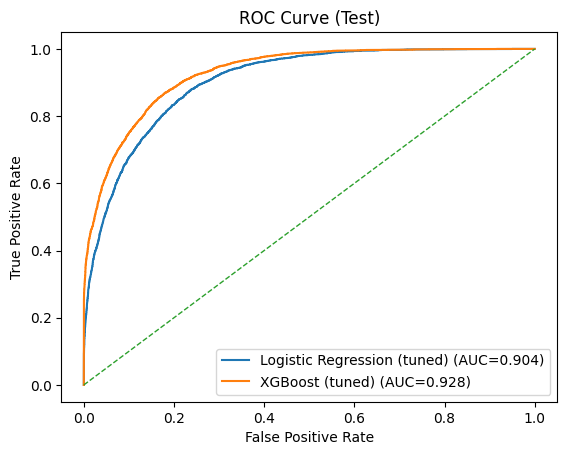

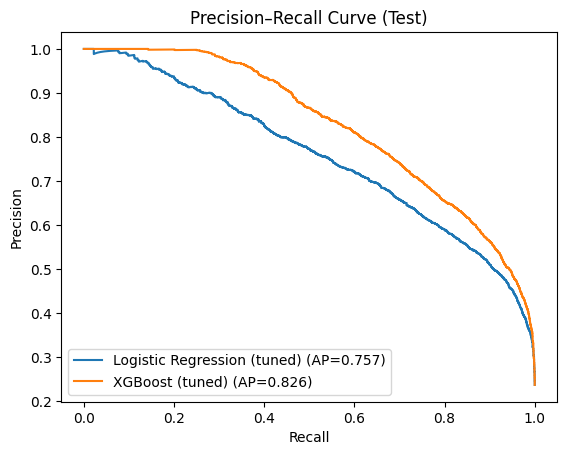

In [56]:
import matplotlib.pyplot as plt

# ROC Curve
plt.figure()
for s in summaries:
    plt.plot(s["FPR"], s["TPR"], label=f'{s["Model"]} (AUC={s["ROC_AUC"]:.3f})')
plt.plot([0,1],[0,1],'--',linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.show()

# Precision–Recall Curve
plt.figure()
for s in summaries:
    plt.plot(s["PR_Recall"], s["PR_Precision"], label=f'{s["Model"]} (AP={s["PR_AUC(AP)"]:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test)")
plt.legend()
plt.show()


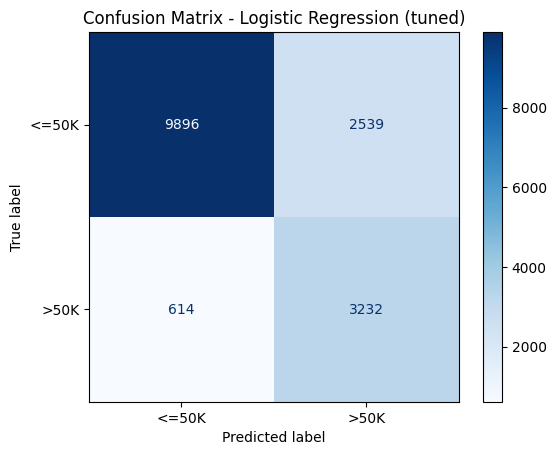

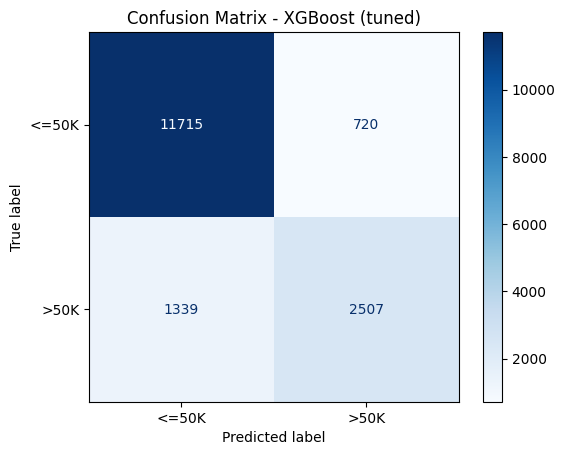

Logistic Regression Confusion Matrix:
 [[9896 2539]
 [ 614 3232]]
XGBoost Confusion Matrix:
 [[11715   720]
 [ 1339  2507]]


In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(estimator, X_test, y_test, model_name):
    """Plot confusion matrix for a fitted model."""
    y_pred = estimator.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    return cm

# Logistic Regression
cm_lr = plot_confusion_matrix(lr_search, X_test_final, y_test_final, "Logistic Regression (tuned)")

# XGBoost
cm_xgb = plot_confusion_matrix(xgb_search, X_test_final, y_test_final, "XGBoost (tuned)")

print("Logistic Regression Confusion Matrix:\n", cm_lr)
print("XGBoost Confusion Matrix:\n", cm_xgb)